**Logistic regression To predict heart disease**

In [136]:
#import libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from statsmodels.stats.outliers_influence import variance_inflation_factor #import VIF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,log_loss,roc_auc_score,roc_curve,precision_score,recall_score,f1_score
from sklearn.linear_model import LogisticRegression

In [137]:
#to display all columns and rows of dataframe 
pd.set_option('display.max_columns',None) 

In [100]:
#Read data
df_original=pd.read_csv("heart_disease.csv")
df_original.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [101]:
df_original.shape

(4238, 16)

In [102]:
df=df_original.copy() 

**Data Cleaning**

In [103]:
df.info(), df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


(None,
 male                  2
 age                  39
 education             4
 currentSmoker         2
 cigsPerDay           33
 BPMeds                2
 prevalentStroke       2
 prevalentHyp          2
 diabetes              2
 totChol             248
 sysBP               234
 diaBP               146
 BMI                1363
 heartRate            73
 glucose             143
 TenYearCHD            2
 dtype: int64)

In [104]:
#1-check null
df.isnull().sum(), df.shape

(male                 0
 age                  0
 education          105
 currentSmoker        0
 cigsPerDay          29
 BPMeds              53
 prevalentStroke      0
 prevalentHyp         0
 diabetes             0
 totChol             50
 sysBP                0
 diaBP                0
 BMI                 19
 heartRate            1
 glucose            388
 TenYearCHD           0
 dtype: int64,
 (4238, 16))

In [105]:
#remove nulls where any null is there in a row
df.dropna(axis=0,inplace=True)

In [106]:
df.reset_index(drop=True,inplace=True)

In [107]:
#2-duplicate check
df.duplicated().any() #no duplicates were found

False

In [108]:
#3-remove columns with single value
df.nunique()

male                  2
age                  39
education             4
currentSmoker         2
cigsPerDay           33
BPMeds                2
prevalentStroke       2
prevalentHyp          2
diabetes              2
totChol             241
sysBP               231
diaBP               142
BMI                1297
heartRate            72
glucose             138
TenYearCHD            2
dtype: int64

**Data Preprocessing**

In [109]:
#assumption in Logisticreg- target is binary, inputs don't have correlation
#1-multicollinearity check, check for each input-->target and if values near to 0 remove that input feature 
df.corr()
#output says remove->hearrate,BMI,totchol,diabetes,prevalentstroke,BPmeds,cigsPerDay,currentSmoker,education,male but my intiution says don't remove them

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
male,1.000000,-0.024387,0.017677,0.206778,0.331243,-0.052128,-0.002308,0.000806,0.013833,-0.070229,-0.045484,0.051575,0.072867,-0.114923,0.003048,0.091745
age,-0.024387,1.000000,-0.158961,-0.210862,-0.189099,0.134670,0.050864,0.306693,0.109027,0.267764,0.388551,0.208880,0.137172,-0.002685,0.118245,0.233810
education,0.017677,-0.158961,1.000000,0.025253,0.013527,-0.013647,-0.030353,-0.079100,-0.039547,-0.012956,-0.124511,-0.058502,-0.137280,-0.064254,-0.031874,-0.063068
currentSmoker,0.206778,-0.210862,0.025253,1.000000,0.773819,-0.051936,-0.038159,-0.107561,-0.041859,-0.051119,-0.134371,-0.115748,-0.159574,0.050452,-0.053346,0.019176
cigsPerDay,0.331243,-0.189099,0.013527,0.773819,1.000000,-0.046479,-0.036283,-0.069890,-0.036934,-0.030222,-0.094764,-0.056650,-0.086888,0.063549,-0.053803,0.052159
BPMeds,-0.052128,0.134670,-0.013647,-0.051936,-0.046479,1.000000,0.113119,0.263047,0.049051,0.094011,0.271291,0.199750,0.105603,0.012894,0.054210,0.089116
prevalentStroke,-0.002308,0.050864,-0.030353,-0.038159,-0.036283,0.113119,1.000000,0.066098,0.009619,0.012697,0.061080,0.055878,0.036478,-0.017020,0.016051,0.048351
prevalentHyp,0.000806,0.306693,-0.079100,-0.107561,-0.069890,0.263047,0.066098,1.000000,0.080623,0.167074,0.697790,0.617634,0.302917,0.147333,0.087129,0.181556
diabetes,0.013833,0.109027,-0.039547,-0.041859,-0.036934,0.049051,0.009619,0.080623,1.000000,0.048371,0.102574,0.050767,0.088970,0.060996,0.614817,0.093397
totChol,-0.070229,0.267764,-0.012956,-0.051119,-0.030222,0.094011,0.012697,0.167074,0.048371,1.000000,0.220130,0.174986,0.120799,0.093057,0.049749,0.091127


<AxesSubplot:>

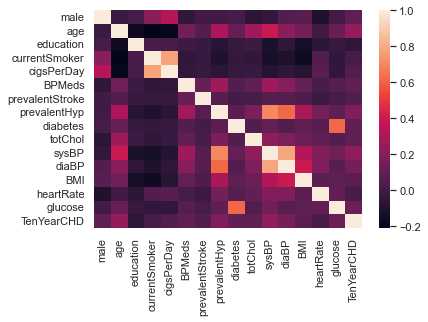

In [110]:
sns.heatmap(df.corr())

In [111]:
#multicollinearity via VIF
#VIF<=4 no multicl, VIF>=10 high multicoll(drop them)
vif_data=pd.DataFrame()
vif_data['Features']=df.columns
vif_data['vif']=[variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
vif_data


,Features,vif
0,male,2.172204
1,age,41.099019
2,education,4.660650
3,currentSmoker,4.931395
4,cigsPerDay,4.301806
5,BPMeds,1.142349
6,prevalentStroke,1.024216
7,prevalentHyp,2.411629
8,diabetes,1.598089
9,totChol,32.173617


In [112]:
#lets try to drop sysBP
temp=df.drop(['sysBP','diaBP'],axis=1)

vif_data=pd.DataFrame()
vif_data['Features']=temp.columns
vif_data['vif']=[variance_inflation_factor(temp.values, i) for i in range(len(temp.columns))]
vif_data

,Features,vif
0,male,2.120954
1,age,35.281933
2,education,4.543238
3,currentSmoker,4.924477
4,cigsPerDay,4.301692
5,BPMeds,1.130454
6,prevalentStroke,1.023855
7,prevalentHyp,1.743055
8,diabetes,1.575461
9,totChol,31.200437


**Create model via statsmodel to view summary with temp,df and df_original**

In [113]:
#1-Create model via temp

In [114]:
temp

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3651,1,58,3.0,0,0.0,0.0,0,1,0,187.0,24.96,80.0,81.0,0
3652,1,68,1.0,0,0.0,0.0,0,1,0,176.0,23.14,60.0,79.0,1
3653,1,50,1.0,1,1.0,0.0,0,1,0,313.0,25.97,66.0,86.0,1
3654,1,51,3.0,1,43.0,0.0,0,0,0,207.0,19.71,65.0,68.0,0


In [115]:
x=temp.iloc[:,:-1]
y=temp.iloc[:,-1]

#1-Feature scaling, lets do via standardscaler

scale=StandardScaler()
x=scale.fit_transform(x)
x


In [116]:
X=sm.add_constant(x)
model_sm_temp=sm.Logit(y,X)
model_sm_temp=model_sm_temp.fit()
model_sm_temp.summary()


Optimization terminated successfully.
         Current function value: 0.379769
         Iterations 7


E:\software\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3656
Model:                          Logit   Df Residuals:                     3642
Method:                           MLE   Df Model:                           13
Date:                Fri, 17 Mar 2023   Pseudo R-squ.:                  0.1101
Time:                        17:23:29   Log-Likelihood:                -1388.4
converged:                       True   LL-Null:                       -1560.3
Covariance Type:            nonrobust   LLR p-value:                 1.676e-65
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -7.4648      0.652    -11.457      0.000      -8.742      -6.188
male                0.5013      0.107      4.681      0.000       0.291       0.711
age                 0.0702      0.006     10.963      0.000       0.058       0.083
education          -0.0601      0.049     -1.227      0.220      -0.156       0.036
currentSmoker       0.0729      0.156      0.468      0.640      -0.232       0.378
cigsPerDay          0.0180      0.006      2.902      0.004       0.006       0.030
BPMeds              0.3116      0.228      1.367      0.172      -0.135       0.758
prevalentStroke     0.6733      0.490      1.373      0.170      -0.288       1.634
prevalentHyp        0.6074      0.108      5.608      0.000       0.395       0.820
diabetes            0.0251      0.314      0.080      0.936      -0.591       0.641
totChol             0.0026      0.001      2.350      0.019       0.000       0.005
BMI                 0.0135      0.012      1.090      0.276      -0.011       0.038
heartRate          -0.0012      0.004     -0.297      0.766      -0.009       0.007
glucose             0.0076      0.002      3.434      0.001       0.003       0.012
===================================================================================
"""

-->as per result we should remove education,currentsmoker,BPmeds,prevalentstroke,diabetes,BMI,heartrate

to be a good model:
0.2<pseudo r-square<0.4 
log-likelihood greater in -ve
ll-null > log-likelihood
llr p-value small

In [ ]:
#now try with df to see summary

In [117]:
df

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3651,1,58,3.0,0,0.0,0.0,0,1,0,187.0,141.0,81.0,24.96,80.0,81.0,0
3652,1,68,1.0,0,0.0,0.0,0,1,0,176.0,168.0,97.0,23.14,60.0,79.0,1
3653,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
3654,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0


In [118]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]

X=sm.add_constant(x)
model_sm_df=sm.Logit(y,X)
model_sm_df=model_sm_df.fit()
model_sm_df.summary()

Optimization terminated successfully.
         Current function value: 0.376668
         Iterations 7


E:\software\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3656
Model:                          Logit   Df Residuals:                     3640
Method:                           MLE   Df Model:                           15
Date:                Fri, 17 Mar 2023   Pseudo R-squ.:                  0.1174
Time:                        17:27:41   Log-Likelihood:                -1377.1
converged:                       True   LL-Null:                       -1560.3
Covariance Type:            nonrobust   LLR p-value:                 8.027e-69
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.3222      0.715    -11.632      0.000      -9.725      -6.920
male                0.5551      0.109      5.090      0.000       0.341       0.769
age                 0.0635      0.007      9.499      0.000       0.050       0.077
education          -0.0475      0.049     -0.962      0.336      -0.144       0.049
currentSmoker       0.0709      0.157      0.452      0.651      -0.236       0.378
cigsPerDay          0.0179      0.006      2.874      0.004       0.006       0.030
BPMeds              0.1623      0.234      0.692      0.489      -0.297       0.621
prevalentStroke     0.6935      0.490      1.417      0.157      -0.266       1.653
prevalentHyp        0.2346      0.138      1.700      0.089      -0.036       0.505
diabetes            0.0395      0.315      0.125      0.900      -0.579       0.658
totChol             0.0023      0.001      2.062      0.039       0.000       0.005
sysBP               0.0154      0.004      4.043      0.000       0.008       0.023
diaBP              -0.0041      0.006     -0.642      0.521      -0.017       0.008
BMI                 0.0066      0.013      0.518      0.605      -0.018       0.032
heartRate          -0.0032      0.004     -0.772      0.440      -0.012       0.005
glucose             0.0071      0.002      3.189      0.001       0.003       0.012
===================================================================================
"""

-->as per result we should remove education,currentsmoker,BPmeds,prevalentstroke,diabetes,BMI,heartrate, diabp
but above model is better as compare 

Create model via logisticregression for both df and temp

In [127]:
x=temp.iloc[:,:-1]
y=temp.iloc[:,-1]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

scale=StandardScaler()
x_train=scale.fit_transform(x_train)
x_test=scale.fit_transform(x_test)

model_log_temp=LogisticRegression()
model_log_temp=model_log_temp.fit(x_train,y_train)

model_log_temp_yhat=model_log_temp.predict(x_test)



In [130]:
confusion_matrix(y_test,model_log_temp_yhat)

array([[618,   5],
       [101,   8]], dtype=int64)

In [132]:
accuracy_score(y_test,model_log_temp_yhat) #accuracy

0.855191256830601

In [144]:
print(confusion_matrix(y_test,model_log_temp_yhat))
print(classification_report(y_test,model_log_temp_yhat))
print(log_loss(y_test,model_log_temp_yhat))

[[618   5]
 [101   8]]
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       623
           1       0.62      0.07      0.13       109

    accuracy                           0.86       732
   macro avg       0.74      0.53      0.53       732
weighted avg       0.82      0.86      0.80       732

5.001522262087


model with df 

In [133]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

scale=StandardScaler()
x_train=scale.fit_transform(x_train)
x_test=scale.fit_transform(x_test)

model_log_df=LogisticRegression()
model_log_df=model_log_df.fit(x_train,y_train)

model_log_df_yhat=model_log_df.predict(x_test)

In [141]:
print(confusion_matrix(y_test,model_log_df_yhat))

[[617   6]
 [ 99  10]]


In [140]:
print(accuracy_score(y_test,model_log_df_yhat)) #accuracy

0.8565573770491803


In [139]:
print(classification_report(y_test,model_log_df_yhat))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       623
           1       0.62      0.09      0.16       109

    accuracy                           0.86       732
   macro avg       0.74      0.54      0.54       732
weighted avg       0.83      0.86      0.81       732



In [142]:
print(log_loss(y_test,model_log_df_yhat))

4.9543392336751415
